In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Read the data
df_loan = pd.read_csv('loan_data_with_features.csv')
loan_data = df_loan.copy()

In [3]:
loan_data

,Age,Gender,Income,Credit_Score,Loan_Amount,Loan_Term,Employment_Status,Interest_Rate,Debt_To_Income_Ratio,Education_Level,...,Credit_Score_Group,Income_Group,Term_Category,Gender_Encoded,Employment_Status_Encoded,Education_Level_Encoded,Marital_Status_Encoded,Credit_Score_Group_Encoded,Income_Group_Encoded,Term_Category_Encoded
0,42,Male,589000.0,675,244000.0,24,Employed,8.75,5.4,High School,...,Medium,Very_Low,Medium,1,0,1,2,2,4,1
1,61,Male,693000.0,538,648000.0,36,Employed,12.86,13.8,Bachelor,...,Very_Low,Low,Medium,1,0,0,1,4,1,1
2,51,Female,985000.0,712,1254000.0,36,Employed,7.64,10.5,PhD,...,Medium,High,Medium,0,0,3,1,2,0,1
3,47,Male,644000.0,754,493000.0,24,Employed,6.38,7.4,Master,...,High,Very_Low,Medium,1,0,2,1,0,4,1
4,35,Female,1202000.0,670,2246000.0,48,Employed,8.90,17.1,Master,...,Low,Very_High,Long,0,0,2,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,57,Female,1218000.0,638,536000.0,48,Employed,9.86,5.8,Master,...,Low,Very_High,Long,0,0,2,1,1,3,0
4996,34,Female,817000.0,681,450000.0,24,Employed,8.57,5.6,High School,...,Medium,Medium,Medium,0,0,1,0,2,2,1
4997,40,Female,801000.0,651,536000.0,36,Employed,9.47,7.6,PhD,...,Low,Low,Medium,0,0,3,1,1,1,1
4998,54,Male,655000.0,702,855000.0,60,Self-employed,8.94,13.1,High School,...,Medium,Very_Low,Long,1,1,1,0,2,4,0


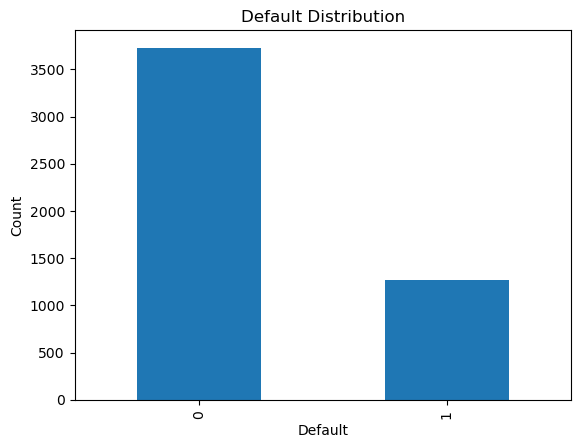

In [4]:
# Display total with graph  
loan_data['Default'].value_counts().plot(kind='bar')
plt.xlabel('Default')
plt.ylabel('Count')
plt.title('Default Distribution')
plt.show()

In [ ]:
# Prepare features
X = loan_data[['Debt_To_Income_Ratio', 'Interest_Rate', 'Employment_Status_Encoded', 
              'Loan_To_Income_Ratio', 'Credit_Score', 'Loan_Amount',
              'Age', 'Previous_Loans', 'Payment_To_Income_Ratio', 'Monthly_Payment']]

# Prepare target
y = loan_data['Default']    

In [6]:
# Apply SMOTE technique
smote=SMOTE(sampling_strategy='minority')
x_sm,y_sm=smote.fit_resample(X,y)

df_sm=pd.concat([x_sm,y_sm],axis=1)

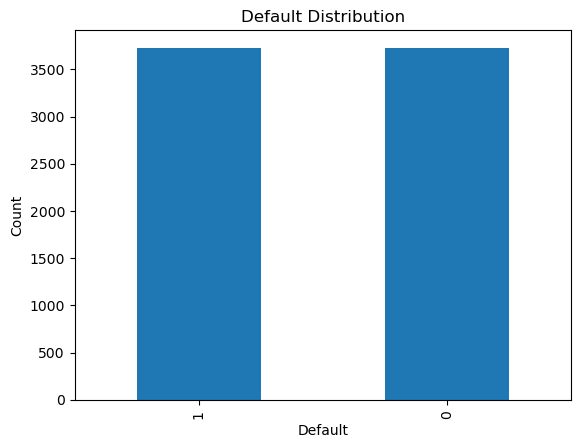

In [7]:
# Display total with graph  
df_sm['Default'].value_counts().plot(kind='bar')
plt.xlabel('Default')
plt.ylabel('Count')
plt.title('Default Distribution')
plt.show()

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=42)

In [9]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],        # Validation set
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred)*100,'%')

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       752
           1       0.78      0.68      0.73       739

    accuracy                           0.75      1491
   macro avg       0.75      0.75      0.74      1491
weighted avg       0.75      0.75      0.74      1491

Accuracy: 74.58081824279007 %


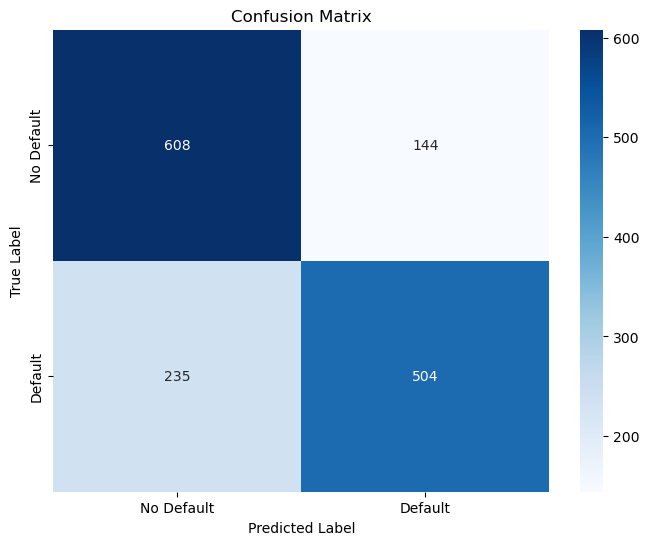

In [11]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

In [12]:
print('ROC AUC Score:',roc_auc_score(y_test, y_pred)*100,'%')

ROC AUC Score: 74.52566723289092 %


In [18]:
# Save the model
pickle.dump(xgb_model, open('loan_default_model.pkl', "wb"))